# Data preparation
### Multiclass B-I-O without hierarchy

In [1]:
from dataprep_utils import (
    original_dataset_info,
    unified_dataset_info,
    create_label_dict,
    unify_text_and_labels_multiclass_no_hierarchy,
    unify_text_and_labels_multiclass_simplelabels,
    split_paths,
    compare_label_dist)
from utils import load_documents
import json

### Original dataset 


=== Dataset Information ===

Number of text files: 51
Number of label files: 51

=== Original dataset labels ===
Article: 9243
Exhibit: 6190
Section: 2303
Introduction of Parties: 396
Table of Contents: 365
Preamble: 337
Signature: 236
Contract Title: 68
Reference Number/Date: 10
Other: 7

Number of distinct labels: 10



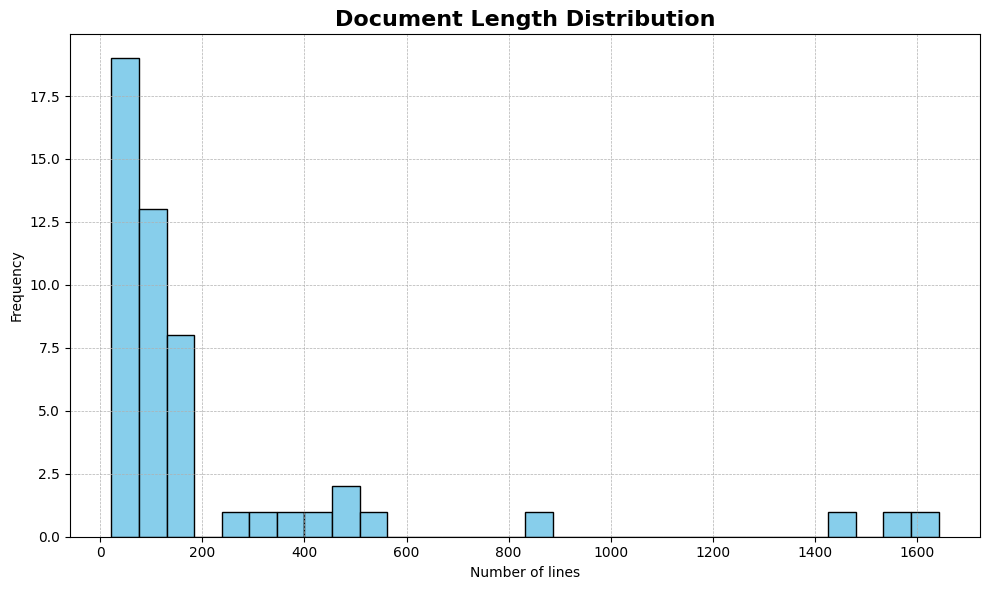

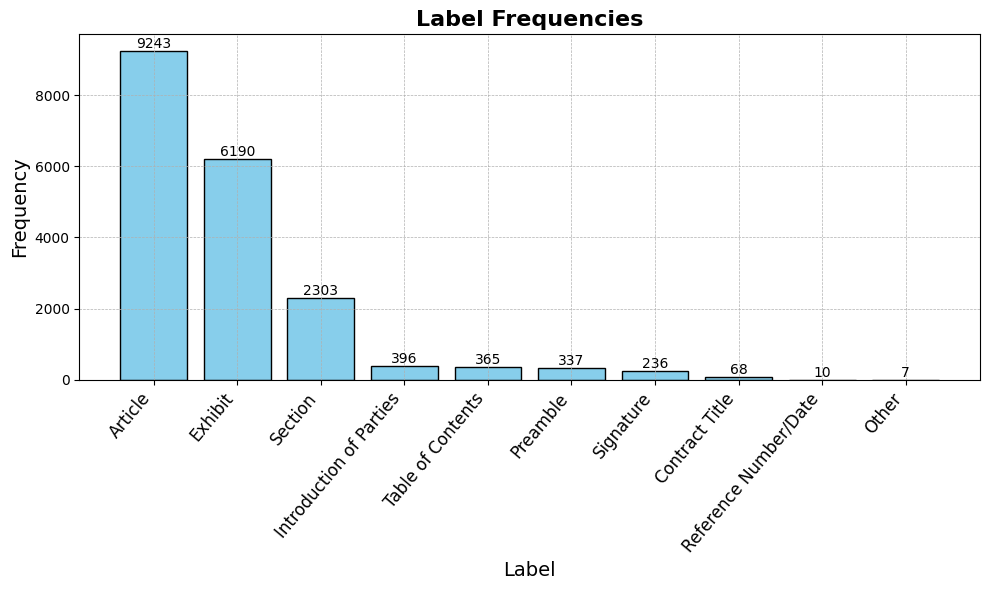

In [2]:
LABELS_PATH = 'dataset/labels'
TEXTS_PATH = 'dataset/texts'
SAVE_PATH = 'dataset/unified'
LABELS_DICT_PATH = 'dataset'

original_dataset_info(TEXTS_PATH, LABELS_PATH)

### Create unified dataset (texts + labels) and save to new JSON files

In [3]:
unify_text_and_labels_multiclass_no_hierarchy(TEXTS_PATH, LABELS_PATH, SAVE_PATH)
#unify_text_and_labels_multiclass_simplelabels(TEXTS_PATH, LABELS_PATH, SAVE_PATH)


Unifying text and labels, using a non-hierarchical approach...


In [4]:
create_label_dict(SAVE_PATH, LABELS_DICT_PATH)

Labels dictionary: 
B-Article: 0
B-Contract Title: 1
B-Exhibit: 2
B-Introduction of Parties: 3
B-Preamble: 4
B-Reference Number/Date: 5
B-Section: 6
B-Signature: 7
B-Table of Contents: 8
I-Article: 9
I-Contract Title: 10
I-Exhibit: 11
I-Introduction of Parties: 12
I-Preamble: 13
I-Section: 14
I-Signature: 15
I-Table of Contents: 16
O: 17


### New Dataset


=== Unified Dataset Information ===



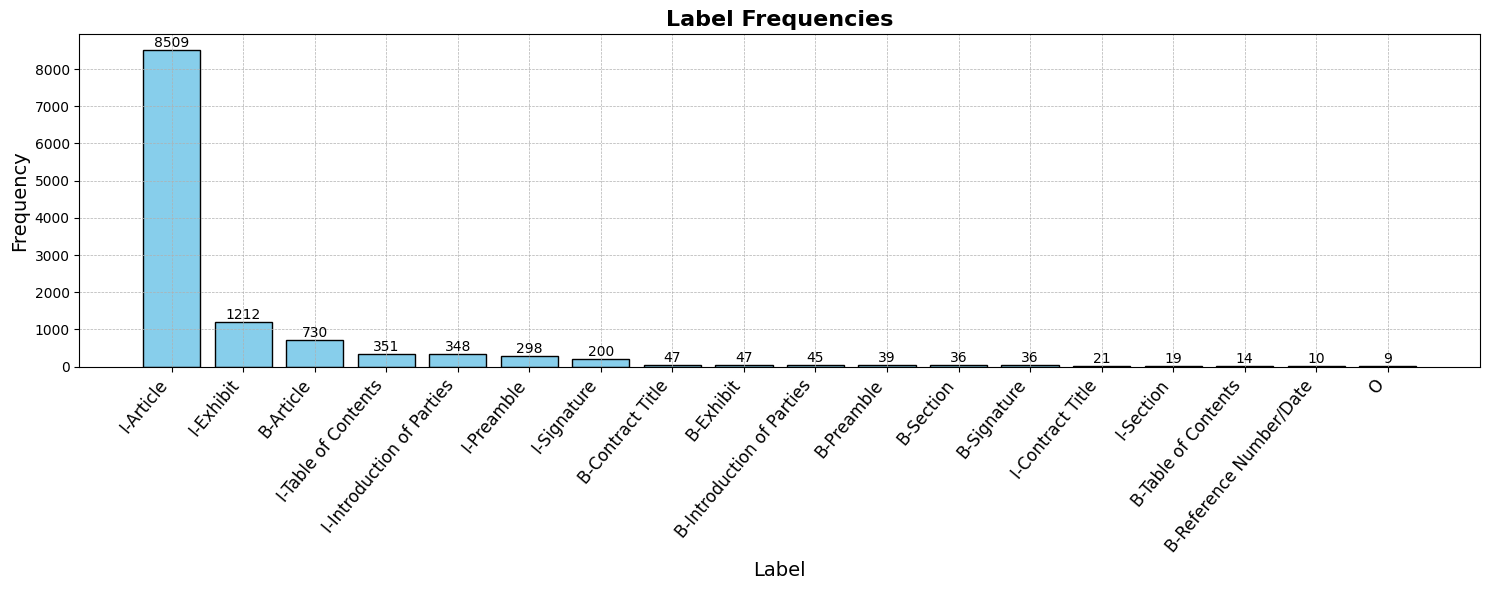


Final labels:

I-Article: 8509
I-Exhibit: 1212
B-Article: 730
I-Table of Contents: 351
I-Introduction of Parties: 348
I-Preamble: 298
I-Signature: 200
B-Contract Title: 47
B-Exhibit: 47
B-Introduction of Parties: 45
B-Preamble: 39
B-Section: 36
B-Signature: 36
I-Contract Title: 21
I-Section: 19
B-Table of Contents: 14
B-Reference Number/Date: 10
O: 9

Number of distinct labels: 18


In [5]:
unified_dataset_info(SAVE_PATH)

### Train, validation, test split


Jensen-Shannon Divergence:
  Train vs Validation: 0.1565
  Train vs Test: 0.1504
  Validation vs Test: 0.1803


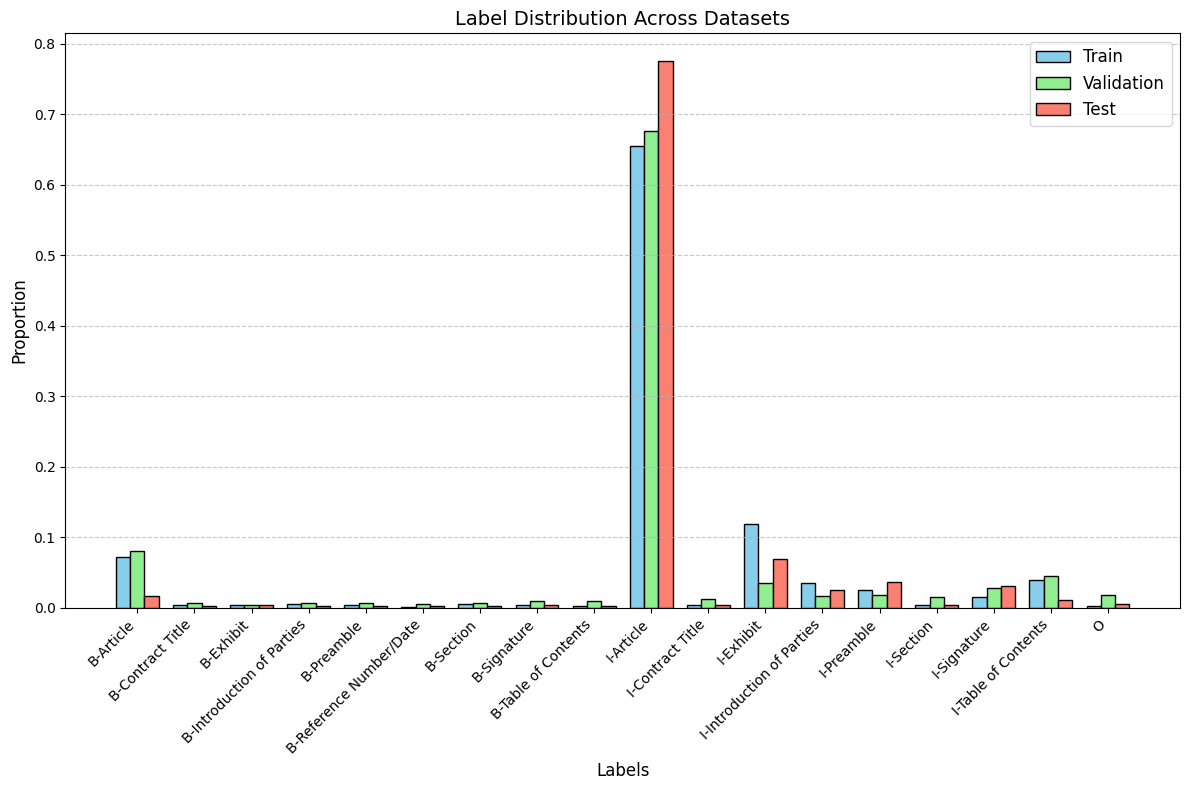

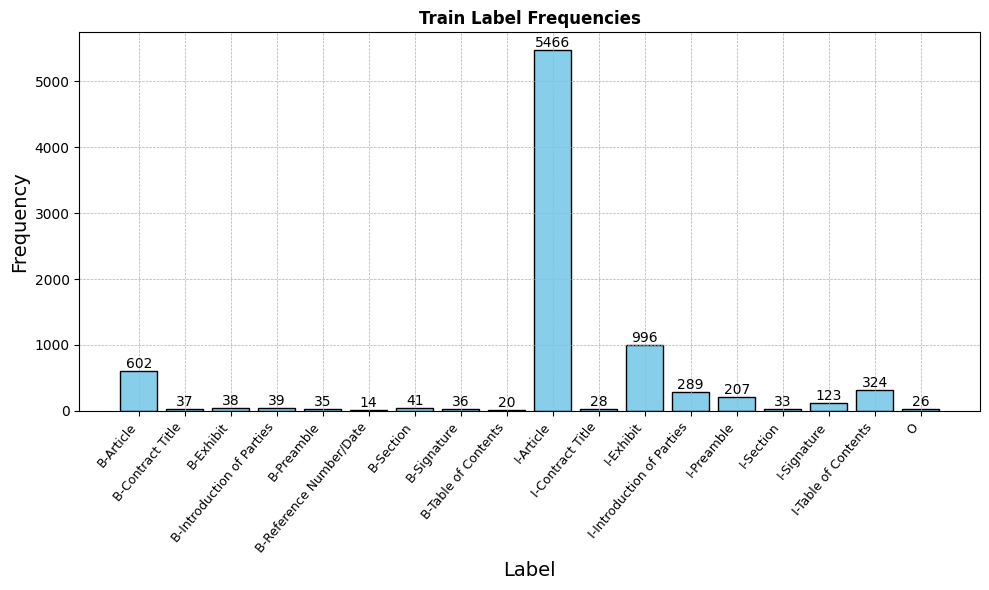

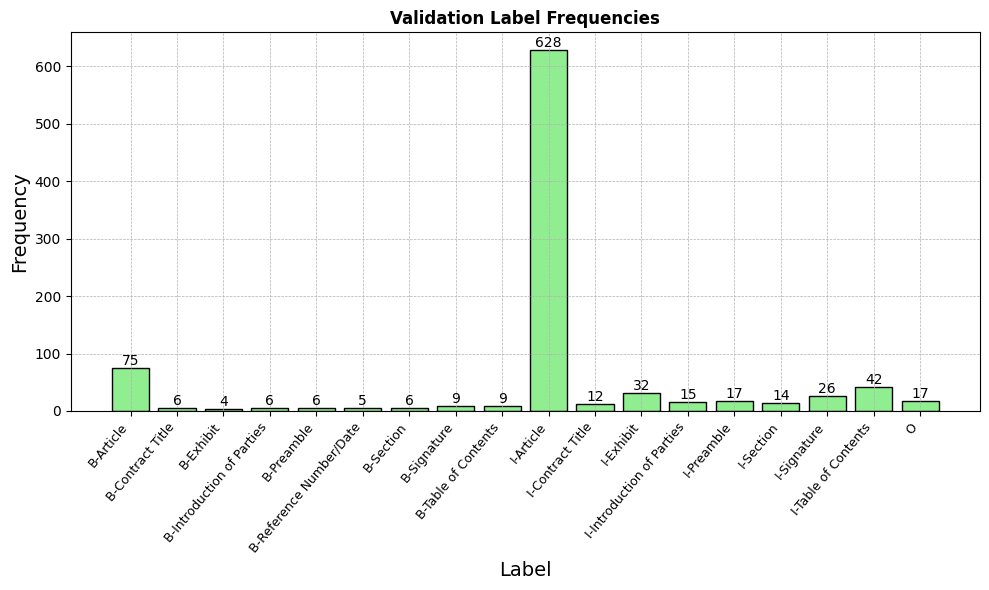

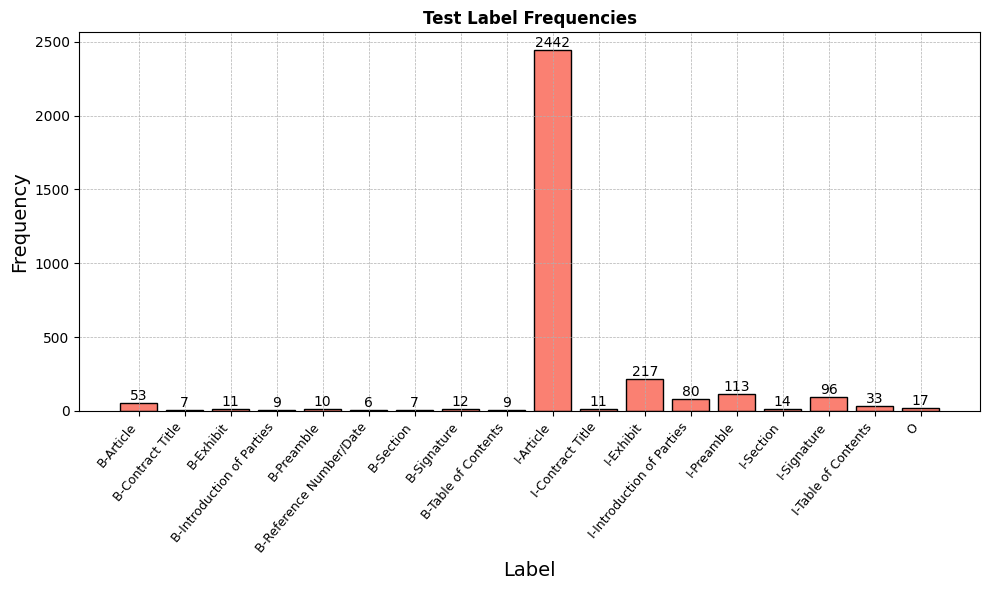

In [6]:
TEST_RATIO = 0.1
VAL_RATIO = 0.1
DATASET_PATH = "dataset/unified"
SPLIT_PATH = "dataset"
LABELS_DICT_PATH = "dataset/labels_dict.json"
SPLIT_SEED = 2

labels_dict = json.load(open(LABELS_DICT_PATH, "r"))

train_paths, val_paths, test_paths = split_paths(data_path=DATASET_PATH, split_path=SPLIT_PATH, test_ratio=TEST_RATIO, val_ratio=VAL_RATIO, seed=SPLIT_SEED)
train_documents = load_documents(train_paths)
val_documents = load_documents(val_paths)
test_documents = load_documents(test_paths)
compare_label_dist(train_documents, val_documents, test_documents, labels_dict)

### Compute allowed transitions for CRF 

In [7]:
from dataprep_utils import get_files
import numpy as np
import json

SAVE_PATH_CONSTRAINTS = 'dataset/'

A = np.zeros((len(labels_dict) + 2, len(labels_dict) + 2))
file_paths = get_files(DATASET_PATH, 'json')
start_label = len(labels_dict)
end_label = len(labels_dict) + 1

for file_path in file_paths:
    with open(DATASET_PATH + '/' + file_path, 'r') as f:
        data = json.load(f)
        past_label = start_label
        for block in data:
            label_name = block['label']
            label_code = labels_dict[label_name]
            if past_label is not None:
                A[past_label][label_code] += 1
            past_label = label_code
        A[past_label][end_label] += 1
            
allowed_transitions = A > 0

# create list of tuples (from_tag_id, to_tag_id) containing the forbidden transitions
constraints = []
for i in range(allowed_transitions.shape[0]):
    for j in range(allowed_transitions.shape[1]):
        if allowed_transitions[i][j]:
            constraints.append((i, j))

json.dump(constraints, open(SAVE_PATH_CONSTRAINTS+'constraints.json', 'w'))